# Práctica - Deep Learning
### Álvaro León - 11 de mayo de 2020.

El siguiente ejercicio consiste en la elaboración de un modelo de clasificación de imágenes de osos, según su especie, a través de deep learning. Dentro del mundo de deep learning, la  clasificación de imágenes se asocia con la asignación *multi-label*: involucra la extracción de información de una imagen y su asociación con una o más etiquetas. Cabe destacar que la evaluación supone la utilización de arquitecturas de redes pre-entrenadas. 

Así, el documento consta de las siguientes partes:

+ [EDA: Análisis exploratorio de datos](#EDA)
    - [Balanceo de los datos](#Balance)
    - [Características de las imágenes](#Imagenes)
+ [Modelos](#Modelos)
    - [Consideraciones sobre muestreo](#Muestreo)
    - [Modelo 1: Arquitectura VGG16](#Modelo1)
    - [Modelo 2: Arquitectura MobileNetV2](#Modelo2)
    - [Testeo de modelo ganador](#Ganador)
+ [Conclusiones](#Conclusiones)
+ [Fuentes](#Fuentes)


**Preámbulo** 
<br>Antes de comenzar, y dado que trabajaremos con muchos directorios, importamos la función `os`. También, debemos establecer algunos parámetros para (i) evitar que TensorFlow imprima errores [(referencia)](https://stackoverflow.com/questions/35869137/avoid-tensorflow-print-on-standard-error), y (ii) reiniciar la sesión de Keras. Finalmente, establecemos una semilla para las iteraciones aleatorias de `numpy` y `tensorflow`.

+ `numpy` es una potente librería que permite realizar operaciones matemáticas sobre información estructurada.
+ `pandas` permite manipular datos y *arrays*.
+ `matplotlib` es la herramienta de visualización más popular en Python.
+ `tensorflow` es una plataforma *open-source* para la implementación, entrenamiento y desarrollo de modelos de machine learning.
+ `keras` también, plataforma *open-source* para implementar redes neuronales.

In [1]:
# Impotamos os para restringir mensajes de error y trabajar con directorios
import os, os.path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Restringimos mensaje de error de TensorFlow y reiniciamos la sesión de Keras.
tf.get_logger().setLevel('ERROR')
tf.keras.backend.clear_session()

# Establecemos semilla
from numpy.random import seed
seed(42) # <- Para Numpy
tf.random.set_seed(42) # <- Para tensorflow

Using TensorFlow backend.


# <a id='EDA'>EDA: Análisis exploratorio de datos</a>

Como se ha dicho más arriba, el ejercicio consiste en la elaboración del mejor modelo de clasificación de osos. Por tanto (sorpresa!) nuestros datos son imágenes de osos: negros, grises y peluches. La procedencia de los datos es desconocida: no sabemos si han sido descargadas de internet o corresponden a un repositorio privado, por señalar un par de ejemplos. Debemos tener esto en mente a la hora de elaborar el set de datos de prueba, pues si todos los datos se consiguen desde internet es probable que algunos samples se repitan.

## <a id='Balance'>Balanceo de los datos</a>

En machine learning en general -incluido deep learning-, uno de los problemas más comunes con los que hay que enfrentarse es el desbalanceo de los datos de entrenamiento. Esto es, que las clases a predecir se encuentran desigualmente distribuidas en el conjunto de datos. ¿Por qué es un problema? Principalmente porque de alguna manera los modelos o algoritmos se vuelven "ciegos" a la clase menos representada, por lo que su capacidad de predecir dicho(s) fenómeno(s) se ve disminuida.

¿Qué hacen en esos casos? En general hay tres estrategias:
+ **Undersampling**, o eliminar aleatoriamente samples de la clase "sobrerepresentada" (en términos relativos), con propósito de balancer suficientemente el conjunto de datos. Aparte de su simplicidad, no parece una buena idea básicamente porque se corre el riesgo de quitarse información valiosa (¡los peligros de la aleatoriedad!).
+ **Oversampling** es justamente lo contrario: aumentar la cantidad de observaciones subrepresentadas simplemente multiplicando ejemplos existentes (el viejo copy/paste). Muy bonito y simple, pero lo cierto es que puede causar sobreajuste.
+ **SMOTE**, o *Synthetic Minority Over-sampling Technique* por sus siglas en inglés, que consiste en la construcción de samples "artificiales" de la clase subrepresentada, copias no-identicas a las existentes a través de *nearest neighbors*. En general es la mejor alternativa (¡de ser necesario balancer, ojo!).

#### Manos a la obra. ¿En qué condicion se encuentran nuestros datos en este sentido?
Perfectamente. Tenemos unos datos completamente balanceados, por lo que no tenemos que aplicar ninguna de las técnicas antes descritas. Pasemos a revisar algunas imágenes.

In [2]:
species = ['black', 'grizzly', 'teddys']
for s in species:
    dir = 'data/osos/' + s
    list = os.listdir(dir)
    number_files = len(list)
    print('Número de oso',s,':', number_files)

Número de oso black : 80
Número de oso grizzly : 80
Número de oso teddys : 80


## <a id='Imagenes'>Características de las imágenes</a>
Otras características que podemos ir observando al iterar imágenes:
+ Contamos con imágenes en colores, y por tanto tridimensionales (salvo alguna excepción).
+ En general, los osos reales (negros y grises) se encuentran en entornos naturales como bosques, rios, o montañas.
+ Además, componen las imágenes osos en distintas etapas vitales (cachorros, adultos, etc.); incluso más de un oso en una misma imagen.
+ En alguna imágenes hay (lamentablemente) personas, y texto.
+ También, son imágenes en que los osos tienen distintas posturas: de lado, de frente, de pie, solo cara, todo el cuerpo, entre otros.
+ Los osos de peluche, en cambio, tienen características muy distintas: en algunos casos, colores artificuales (rosa, plata, celeste, celeste, entre otros). Además, efectivamente algunos son peluches, pero también hay pendientes, dibujos, y bocetos. Podría decirse, incluso, que no corresponde estrictamente la etiqueta "teddy bear"; aunque vale decir que la mayoría son peluches. Serán -posiblemente- los más difíciles de clasificar.

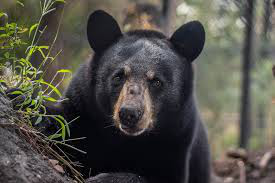

In [3]:
from tensorflow.keras.preprocessing import image
image.load_img('data/osos/black/00000000.jpg')

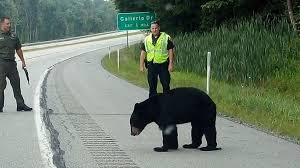

In [4]:
image.load_img('data/osos/black/00000036.jpg')

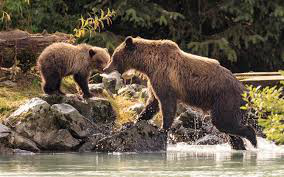

In [5]:
image.load_img('data/osos/grizzly/00000000.jpg')

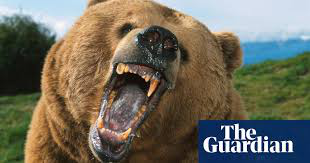

In [6]:
image.load_img('data/osos/grizzly/00000004.jpg')

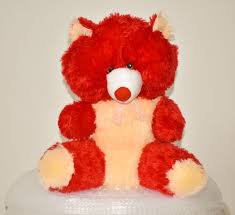

In [7]:
image.load_img('data/osos/teddys/00000065.jpg')

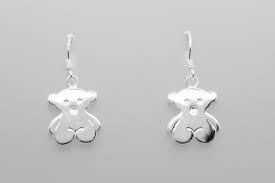

In [8]:
image.load_img('data/osos/teddys/00000026.jpg')

# <a id='Modelos'>Elaboración de modelos</a>

## <a id='Muestreo'>Consideraciones sobre muestreo</a>
Sabemos que una etapa crítica en la elaboración de modelos de machine learning es el muestreo, o dicho de otra forma, la separación de nuestros datos entre aquellos que destinaremos a construir y aquellos que dejaremos para testear cualquiera sea el modelo.

En las etapas tempranas del machine learning el conjunto de datos que se destinaba a testear los modelos era relativamente grande. En general, es comun ver en proyectos de ese tipo particiones de 77% train y 33% test (o 70% train, 15% dev y 15% test). No obstante, en la era del big data y el aprendizaje profundo, la proporción de datos que destinamos a validar y testear es mucho menor. Por ejemplo, frente a un proyecto con 1 millón de registros, normalmente pueden destinarse el 98% a entrenar modelos, el 1% a validarlos y el restante 1% a testearlo. 

Ahora, pongamos los pies en la tierra: nuestro pequeño proyecto está a kilómetros luz de conjuntos de datos de ese tamaño. De hecho, hemos visto que sólo disponemos de 240 imágenes. ¿Significa eso que nuestro proyecto no tiene futuro? Para nada. Dejémos que **Francois Chollet** hable por nosotros: 

> *A message that I hear often is that "deep learning is only relevant when you have a huge amount of data". While not entirely incorrect, this is somewhat misleading. Certainly, deep learning requires the ability to learn features automatically from the data, which is generally only possible when lots of training data is available --especially for problems where the input samples are very high-dimensional, like images. However, convolutional neural networks --a pillar algorithm of deep learning-- are by design one of the best models available for most "perceptual" problems (such as image classification), even with very little data to learn from. Training a convnet from scratch on a small image dataset will still yield reasonable results, without the need for any custom feature engineering. Convnets are just plain good. They are the right tool for the job* // [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

Entonces, ¿necesitamos realmente dividir nuestros datos? Recordemos que los datos de entrenamiento son eso... registros expuestos a nuestra red neuronal durante entrenamiento. Por su parte, los datos de validación se utilizan durante el entrenamiento para evaluar el rendimiento de los modelos experimentados. Y los datos de prueba, finalmente, son registros que el modelo no ha visto antes y que entregan una evaluación final de la performance del modelo "ganador", o el que hemos decidido llevar a despliegue. Estos dos últimos suenan bastante parecidos, ¿no? Lo cierto es que no lo son, pero en algunas ocasiones puede precindirse de los datos de testeo (dividiéndo, sólo, entre train y dev). 

<img src="muestreo.png">

Así las cosas, ¿cómo procederemos? **En definitiva**, para mentener la convención, particionaremos nuestros datos en train/dev; y posteriormente construiremos un conjunto de datos de test totalmente independientes, para evaluar el rendimiento del modelo con datos desconocidos. Cabe destacar que más tarde desplegaremos técnicas de *data augmentation* para palear en parte la escasez de datos.

**Nota**: [Andrew Ng](https://en.wikipedia.org/wiki/Andrew_Ng) ha destacado que es una buena práctica que los datos de validación y testeo provengan de la misma distribución: por ejemplo, en imágenes, al originarse de distinta manera pueden tener distintas calidades, cuestión que impactará sobre la efectividad del modelo para reconocer patrones.

### <a id='Modelo1'>Arquitectura VGG16</a>

En primer lugar, acudiremos al modelo **VGG16**: Este es un modelo de red neuronal convulsional (CNN: Convolutional Neural Network) pre entrenado con [ImageNet](http://www.image-net.org/), y propuesto por K. Simonyan y A. Zisserman de la Universidad de Oxford, en el paper "*Very Deep Convolutional Networks for Large-Scale Image Recognition"*.

Como muestra la imagen ulterior, VGG16 exige que la capa de entrada tenga dimensiones 224x224xRGB, por lo que en el pre-procesado será de las primeras cosas a ajustar. Como veremos a continuación, descartaremos la última capa de VGG16 y añadiremos un par de capas para agregar complejidad relativa a nuestros datos.


<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png">

**Referencia**: https://neurohive.io/en/popular-networks/vgg16/

> **En primer lugar, entonces, importamos VGG16 desde Keras. Además, también desde Keras, importamos dos capas que añadiremos: una densa y un global pooling.**

In [9]:
# Importamos modelos pre-entrenados
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D

In [10]:
model_vgg16 = VGG16(weights = 'imagenet',
                    include_top = False)               # Descartamos la última capa de 1.000 neuronas.


# Vamos a hacerlo con el método funcional (no secuencial)
x = model_vgg16.output                                 # Desde la última capa de model_vgg16...
x = GlobalAveragePooling2D()(x)                        # Agregamos a x una capa GlobalAveragePooling2D 
x = Dense(512, activation='relu')(x)                   # Luego una capa densa de 512 neuronas, con activación ReLU
preds = Dense(3, activation='softmax')(x)              # Finalmente, una capa densa con 3 neuronas y activación Softmax (tipicamente usada para output)

> **Creamos el primer modelo con VGG16 más las capas que hemos añadido. Además, visualizamos sus capas, dimensiones y parámetros.**

In [11]:
from keras.models import Model
model_1 = Model(inputs = model_vgg16.input, # el input es el modelo base
               outputs = preds) # el output es la última capa
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

> **Si observamos la tabla anterior, vemos que VGG16 tiene 19 capas (desde input hasta block5_conv3). Lo que haremos será definir que el modelo "aprenda" sólo en las 3 capas que hemos añadido, para que ese aprendizaje se incorpore a la potencialidad de VGG16.**

In [12]:
# Definir las capas de VGG16 como "no-entrenables".
for layer in model_1.layers[:19]:
    layer.trainable=False
    
# Definir las capas adicionales como "entrenables".
for layer in model_1.layers[19:]:
    layer.trainable=True

### Preprocesado

Llegados a este punto realizaremos *data augmentation*. En la práctica, realizaremos copias artificiales de las imágenes con variaciones de las originales para entregarle más información al modelo. Lo ideal sería aumentar los datos al comienzo del ejercicio, pero algunas arquitecturas tienen funciones de preprocesado específicas, por lo que haremos acá.

Algunas variaciones que pueden aplicarse son rotación, zoom, iluminación, giro horizontal y/o vertical, entre otros (ver la documentación de *ImageDataGenerator*). Aquí exponemos las que han funcionado mejor para este ejercicio. Además, cabe destacar que se especifica el preprocesado definido para VGG16.

<img src="augmentation.jpeg">

**Referencia**: https://keras.io/api/preprocessing/image/

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16

# Creo el preproceso - Data augmentation
generator = ImageDataGenerator(preprocessing_function = preprocess_vgg16, # Algunas arquitecturas tienen funciones de preproceso específicas.
                               rotation_range = 45,                       # Rotamos las imágenes
                               horizontal_flip = True,                    # Giro horizontal de imágenes
                               zoom_range = 0.2,                          # Zoom aleatorio
                               width_shift_range = 2,                     # Rango para jugar con el ancho
                               brightness_range = [0.2,1.0],              # Rango para modificar brillo
                               validation_split=0.2)                      # Establecemos el parámetro para el subconjunto de validación

> **Tras el *data augmentation* generamos los conjuntos de entrenamiento y validación. Especificamos el directorio desde donde se extraerán las imágenes y el tamaño de las imágenes que recibirá el modelo. De acuerdo a la proporción de datos que hemos especificado para validación, tenemos 192 registros para entrenar el modelo, y 48 para validarlo.** 

In [14]:
# Genero el conjunto de entrenamiento según datos pre-procesados.
train_generator = generator.flow_from_directory(directory='data/osos/',    # Especificamos la carpeta "madre" de donde recoger las imágenes.
                                                target_size = (224,224),   # Recordar que VGG16 usa inputs de 244x244. 
                                                
                                                # Parámetros
                                                seed=42,
                                                color_mode='rgb',          # Parámetro necesario para especificar que las imágenes son a color
                                                batch_size=3,              # Detalle del batch
                                                class_mode='categorical',  # Categorica porque es clasificación
                                                shuffle=True,              # Parámetro para que desordene las imágenes en cada batch
                                                subset='training')         # Muy importante. Detallo que corresponde a datos de entrenamiento

# Lo mismo con los datos de validación.
validation_generator = generator.flow_from_directory(directory='data/osos/',
                                                     target_size = (224,224),
                                                     seed=42,
                                                     color_mode='rgb',
                                                     batch_size=3,          # Batch 3 es el parámetro que mejor ha funcionado
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     subset='validation')   # Muy importante. Detallo que corresponde a datos de validación.

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


<br>**Finalmente, compilamos el modelo. Aquí algunas consideraciones:**
- Utilizaremos el optimizador Adam, que a diferencia del descenso gradiente clásico, que mantiene un ratio de aprendizaje constante, calcula *learning rates* individuales para los diferentes parámetros a estimar.
- La función de costo a utilizar es entropía cruzada, que como se ve en la fórmula posterior, compara la distribución de las predicciones con la "realidad" o los valores verdaderos.  

$$\mathcal{L} = - \frac{1}{n}\cdot\sum y_i\cdot log(\widehat{y_i})$$

- Además, la métrica para evaluar el modelo será el clásico *accuracy*.

In [15]:
from keras.optimizers import Adam
model_1.compile(optimizer = 'Adam',                    # Utilizaremos el optimizador 'Adam'
                loss = 'categorical_crossentropy',     # La función de costo será categorical cross entropy
                metrics = ['accuracy'])                # Métrica de evaluación

step_size_train = train_generator.n//train_generator.batch_size              # Debemos establecer el "tamaño" del step para train y test.
validation_steps = validation_generator.n // validation_generator.batch_size

model_1.fit_generator(generator = train_generator,
                                steps_per_epoch = step_size_train,
                                validation_data = validation_generator,  
                                validation_steps = validation_steps,    
                                epochs=10)                                    # Entrenamos con 10 epoch

Epoch 1/10
64/64 [==============================] - 17s 271ms/step - loss: 1.0992 - accuracy: 0.8281 - val_loss: 0.1093 - val_accuracy: 0.8542
Epoch 2/10
64/64 [==============================] - 17s 273ms/step - loss: 0.0882 - accuracy: 0.9635 - val_loss: 8.7489e-05 - val_accuracy: 0.9375
Epoch 3/10
64/64 [==============================] - 18s 275ms/step - loss: 0.0814 - accuracy: 0.9740 - val_loss: 6.8898e-05 - val_accuracy: 0.9583
Epoch 4/10
64/64 [==============================] - 17s 270ms/step - loss: 0.2983 - accuracy: 0.9271 - val_loss: 3.8941e-06 - val_accuracy: 0.8958
Epoch 5/10
64/64 [==============================] - 17s 269ms/step - loss: 0.9104 - accuracy: 0.9062 - val_loss: 0.0000e+00 - val_accuracy: 0.9375
Epoch 6/10
64/64 [==============================] - 17s 270ms/step - loss: 0.2750 - accuracy: 0.9375 - val_loss: 1.3168 - val_accuracy: 0.9583
Epoch 7/10
64/64 [==============================] - 17s 270ms/step - loss: 0.0131 - accuracy: 0.9948 - val_loss: 1.3234 - val_

> **Finalmente, vemos el rendimiento del modelo con los datos de validación: Accuracy de 96%.**

In [16]:
scores = model_1.evaluate_generator(generator = validation_generator,
                                    steps = validation_steps, 
                                    verbose=1)

print("Accuracy = ", scores[1])

16/16 [==============================] - 3s 216ms/step
Accuracy =  0.9583333134651184


### <a id='Modelo2'>Arquitectura MobileNet</a>

En segundo lugar probaremos MobileNet. Esta red neuronal fue diseñada para implementarse en móbiles o dispositivos de bajo poder (no ordenadores). ¿Cómo hizo posible la gente de Google esto? La gran idea detrás de la primera versión de MobileNet es que las capas convulsionales, que se especializan en imágenes con alto costo computacional, pueden ser remplazadas por "*depthwise separable convolutions*" [(más detalles aquí)](https://machinethink.net/blog/mobilenet-v2/).

En general, he leído que MobileNet necesita muchas más epoch que otras arquitecturas. Hemos entrenaremos con 20. Además, por probar cosas distintas, hemos implementado un optimizador "manual", definiendo el *learning rate* y *momentum*. También, definimos manualmente los steps, siendo 32 el número que mejores resultados ha dado. Con todo, lo cierto es que no he conseguido implementar MobileNetV2 correctamente. Aquí dejamos el intento.

**Nota**: Repetiremos bastantes de los pasos detallados para el modelo con VGG16, que no describiremos aquí nuevamente. Aquí sólo añadimos una última de *output* de tres neuronas (3 categorías) con activación *softmax*. El input size de MobileNetV2 también es 224x224 [(ver aquí)](https://keras.rstudio.com/reference/application_mobilenet_v2.html).

In [20]:
# Importamos modelos pre-entrenados
from keras.applications import MobileNet

model_mobnet = MobileNet(weights = 'imagenet') 

x = model_mobnet.output                                # Desde la última capa de model_mobnet...
preds = Dense(3, activation='softmax')(x)              # Finalmente, una capa densa con 3 neuronas y activación Softmax (tipicamente usada para output)

In [21]:
model_2 = Model(inputs = model_mobnet.input,  # El input es el modelo base
                outputs = preds)              # El output es la última capa que hemos detallado
#model_2.summary()                            # Podemos ver la arquitectura de MobileNetV2. Es enorme, así que no lo haremos acá.

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet

# Creo el preproceso - Data augmentation
generator = ImageDataGenerator(preprocessing_function = preprocess_mobilenet, # Algunas arquitecturas tienen funciones de preproceso específicas.
                               rotation_range = 45,                           # Rotamos las imágenes
                               horizontal_flip = True,                        # Giro horizontal de imágenes
                               zoom_range = 0.3,                              # Zoom aleatorio
                               width_shift_range = 2,                         # Rango para jugar con el ancho
                               brightness_range = [0.2,1.0],                  # Rango para modificar brillo
                               validation_split = 0.2)                        # Establecemos el parámetro para el subconjunto de validación

train_generator = generator.flow_from_directory(directory='data/osos/',    # Especificamos la carpeta "madre" de donde recoger las imágenes.
                                                target_size = (224,224),   # Recordar que MobileNetV2 usa inputs de 244x244. 
                                                
                                                # Parámetros
                                                seed=42,
                                                color_mode='rgb',          # Parámetro necesario para especificar que las imágenes son a color
                                                batch_size=3,              # Detalle del batch
                                                class_mode='categorical',  # Categorica porque es clasificación
                                                shuffle=True,              # Parámetro para que desordene las imágenes en cada batch
                                                subset='training')         # Muy importante. Detallo que corresponde a datos de entrenamiento

# Lo mismo con los datos de validación.
validation_generator = generator.flow_from_directory(directory='data/osos/',
                                                     target_size = (224,224),
                                                     seed=42,
                                                     color_mode='rgb',
                                                     batch_size=3,          # Batch 3 es el parámetro que mejor ha funcionado
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     subset='validation')   # Muy importante. Detallo que corresponde a datos de validación.

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [28]:
from tensorflow.keras.optimizers import SGD

model_2.compile(optimizer = SGD(lr=0.01, momentum=0.9),      # Definimos manualmente los parámetros de optimización
                loss = 'categorical_crossentropy',             # La función de costo será categorical cross entropy
                metrics = ['accuracy'])                        # Métrica de evaluación


model_2.fit_generator(generator = train_generator,
                      steps_per_epoch = 32,                         # Definimos manualmente los step en entrenamiento y validación.
                      validation_data = validation_generator,  
                      validation_steps = 32,    
                      epochs=10)                                    # Entrenamos con 10 epoch

Epoch 1/10
32/32 [==============================] - 16s 487ms/step - loss: 1.0868 - accuracy: 0.3750 - val_loss: 1.0597 - val_accuracy: 0.6458
Epoch 2/10
32/32 [==============================] - 13s 406ms/step - loss: 1.0140 - accuracy: 0.6250 - val_loss: 0.8799 - val_accuracy: 0.7083
Epoch 3/10
32/32 [==============================] - 13s 405ms/step - loss: 0.9388 - accuracy: 0.5521 - val_loss: 0.6853 - val_accuracy: 0.8021
Epoch 4/10
32/32 [==============================] - 13s 404ms/step - loss: 0.8462 - accuracy: 0.7292 - val_loss: 0.5675 - val_accuracy: 0.5208
Epoch 5/10
32/32 [==============================] - 13s 406ms/step - loss: 0.8421 - accuracy: 0.6354 - val_loss: 1.0232 - val_accuracy: 0.4583
Epoch 6/10
32/32 [==============================] - 13s 407ms/step - loss: 0.8111 - accuracy: 0.7188 - val_loss: 0.6615 - val_accuracy: 0.4479
Epoch 7/10
32/32 [==============================] - 13s 407ms/step - loss: 0.9607 - accuracy: 0.5521 - val_loss: 0.5242 - val_accuracy: 0.5938

> **Tenemos un accuracy bastante lamentable (51%). Como se ha dicho, no hemos conseguido refinar los hiperparámetros de este modelo. Con más tiempo seguiremos indagando.**

In [29]:
# No necesito crear nuevamente un test o evaluate_generator
scores = model_2.evaluate_generator(generator = validation_generator,
                         steps = 32, 
                         verbose=1)

print("Accuracy = ", scores[1])

32/32 [==============================] - 3s 91ms/step
Accuracy =  0.5104166865348816


### Nota
Hemos intentado implementar **InceptionResNetV2 y NASNetLarge**, sin éxito. 

### <a id='Ganador'>Testeo de modelo ganador</a>

Entre ambos modelos implementados, sin duda la arquitectura VGG16 ha sido la ganadora. En este último apartado revisaremos su rendimiento con datos nuevos.

De este modo, en primer lugar, generamos los datos de test con los parámetros que necesita VGG16 (size input) y el tamaño del step. Luego, vemos el accuracy respecto a estos nuevos datos.

In [32]:
test_generator = generator.flow_from_directory(directory='data/manual_test/',
                                               target_size = (224,224),
                                               seed=42,
                                               color_mode='rgb',
                                               batch_size=3,
                                               class_mode='categorical', # categorica porque es clasificación
                                               shuffle=True) # para que desordene las imágenes en cada batch

test_steps = test_generator.n // test_generator.batch_size

Found 29 images belonging to 3 classes.


En principio, nuestro modelo no conoce estas imágenes. En principio, porque las hemos descargado de internet y esperamos que no coincidan con las del conjunto de datos de entrenamiento (que suponemos también se descargaron de internet). 

**En entrenamiento tuvimos un accuracy de 96%. En cambio, en test sólo hemos alcanzado 85%. En general hay dos recetas básicas para enfrentar la varianza de los modelos (como la aquí presente):**
- Sumas más datos de entrenamiento, y
- Añadir regularización al modelo.

> En este ejercicio no iremos más allá.

In [33]:
scores = model_1.evaluate_generator(generator = test_generator,
                                    steps = test_steps, 
                                    verbose=1)

print("Accuracy = ", scores[1])

9/9 [==============================] - 2s 225ms/step
Accuracy =  0.8518518805503845


**¿Pero dónde falló nuestro modelo?**. Con la siguiente función se puede explorar la predicción del modelo frente a una foto en particular, y con el ciclo siguiente, frente a todas las fotos. Como se ve, el modelo tiene dificultad para clasificar un oso negro que, claramente, tiene un color de pelo bastante particular (más gris que negro).

In [51]:
from numpy import expand_dims
import matplotlib.pyplot as plt

class_dict = {v:k for k, v in train_generator.class_indices.items()}

def predict_image(path): # Función de predictor
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_vgg16(data) # MUY IMPORTANTE! La predicción tiene que ser sobre imágenes igualmente procesadas que en el modelo
    preds = model_1.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    
    # Finalmente
    print(pred) # Imprimer la predicción
    return img # Retorna la imagen (para que se imprima) 

In [52]:
# Aplicamos el modelo a las fotos recopiladas
species = ('teddys', 'grizzly', 'black')
directory  = 'data/manual_test/'

for s in species:
    path = ['data/manual_test/{}'.format(i) for i in os.listdir(directory) if s in i]
    path = ''.join(path)
    print('Prediciendo', s)
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            if filename.endswith('.jpeg'):
                new_path = os.sep.join([dirpath, filename])
                predict_image(new_path)

Prediciendo teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
Prediciendo grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
Prediciendo black
black
black
black
black
black
black
black
grizzly


grizzly


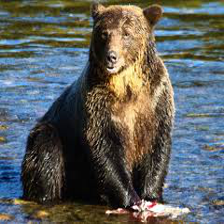

In [35]:
predict_image('data/manual_test/grizzly/images (15).jpeg')

teddys


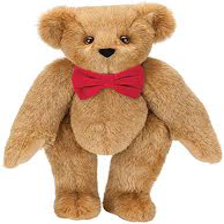

In [36]:
predict_image('data/manual_test/teddys/descarga (3).jpeg')

black


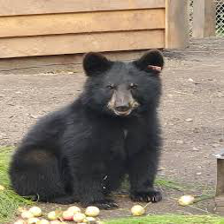

In [37]:
predict_image('data/manual_test/black/0001.jpeg')

grizzly


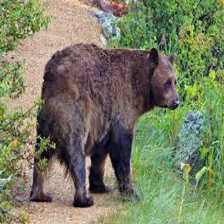

In [39]:
predict_image('data/manual_test/black/0008.jpeg')

# <a id='Fuentes'>Fuentes de información</a>

**Modelos de Keras**
- [Keras pre-trained models](https://keras.io/api/applications/)
- [VGG16](https://keras.io/api/applications/vgg/#vgg16-function)
- [MobileNet version 2](https://machinethink.net/blog/mobilenet-v2/)

**Modelos de clasificación con deep learning en general**
- [Machine Learning Image Classification With TensorFlow](https://towardsdatascience.com/in-depth-machine-learning-image-classification-with-tensorflow-2-0-a76526b32af8)
- [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)


**Ámbitos específicos**
- [Transfer learning from pre-trained models](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)
- [Loss functions in Keras](https://keras.io/api/losses/)
- [Deep learning unbalanced training data? Solve it like this](https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6)
- [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)


